# Searching for the Higgs Boson #

The Standard Model is a theory in particle physics that describes some of the most basic forces of nature. One fundamental particle, the Higgs boson, is what accounts for the *mass* of matter. First theorized in the 1964, the Higgs boson eluded observation for almost fifty years. In 2012 it was finally observed experimentally at the Large Hadron Collider. These experiments produced millions of gigabytes of data.

Large and complicated datasets like these are where deep learning excels. In this notebook, we'll build a Wide and Deep neural network to determine whether an observed particle collision produced a Higgs boson or not.

# The Collision Data #

The collision of protons at high energy can produce new particles like the Higgs boson. These particles can't be directly observed, however, since they decay almost instantly. So to detect the presence of a new particle, we instead observe the behavior of the particles they decay into, their "decay products".

The *Higgs* dataset contains 21 "low-level" features of the decay products and also 7 more "high-level" features derived from these.

# Wide and Deep Neural Networks #

A *Wide and Deep* network trains a linear layer side-by-side with a deep stack of dense layers. Wide and Deep networks are often effective on tabular datasets.[^1]

Both the dataset and the model are much larger than what we used in the course. To speed up training, we'll use Kaggle's [Tensor Processing Units](https://www.kaggle.com/docs/tpu) (TPUs), an accelerator ideal for large workloads.

We've collected some hyperparameters here to make experimentation easier. Fork this notebook by [**clicking here**](https://www.kaggle.com/kernels/fork/12171965) to try it yourself!

In [1]:
# Model Configuration
UNITS = 2 ** 11 # 2048
ACTIVATION = 'relu'
DROPOUT = 0.1

# Training Configuration
BATCH_SIZE_PER_REPLICA = 2 ** 11 # powers of 128 are best

The next few sections set up the TPU computation, data pipeline, and neural network model. If you'd just like to see the results, feel free to skip to the end!

# Setup #

In addition to our imports, this section contains some code that will connect our notebook to the TPU and create a **distribution strategy**. Each TPU has eight computational cores acting independently. With a distribution strategy, we define how we want to divide up the work between them.

In [2]:
# TensorFlow
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# Detect and init the TPU
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local') # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)
    
# Plotting
import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


# Data
from kaggle_datasets import KaggleDatasets
from tensorflow.io import FixedLenFeature
AUTO = tf.data.experimental.AUTOTUNE


# Model
import tf_keras as keras
from tf_keras import layers
from tf_keras import callbacks

E0000 00:00:1755525136.146719      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


Tensorflow version 2.18.0
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1755525159.757159      74 service.cc:148] XLA service 0x584e934335b0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755525159.757197      74 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1755525159.757201      74 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1755525159.757204      74 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1755525159.757209      74 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1755525159.757211      74 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1755525159.757214      74 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1755525159.757216      74 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1755525159.757219      74 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of accelerators:  8


Notice that TensorFlow now detects eight accelerators. Using a TPU is a bit like using eight GPUs at once.

# Load Data #

The dataset has been encoded in a binary file format called *TFRecords*. These two functions will parse the TFRecords and build a TensorFlow `tf.data.Dataset` object that we can use for training.

In [3]:
def make_decoder(feature_description):
    def decoder(example):
        example = tf.io.parse_single_example(example, feature_description)
        features = tf.io.parse_tensor(example['features'], tf.float32)
        features = tf.reshape(features, [28])
        label = example['label']
        return features, label
    return decoder

def load_dataset(filenames, decoder, ordered=False):
    AUTO = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = (
        tf.data
        .TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(ignore_order)
        .map(decoder, AUTO)
    )
    return dataset

In [4]:
dataset_size = int(11e6)
validation_size = int(5e5)
training_size = dataset_size - validation_size

# For model.fit
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = training_size // batch_size
validation_steps = validation_size // batch_size

# For model.compile
steps_per_execution = 256

In [5]:
feature_description = {
    'features': FixedLenFeature([], tf.string),
    'label': FixedLenFeature([], tf.float32),
}
decoder = make_decoder(feature_description)

# data_dir = KaggleDatasets().get_gcs_path('higgs-boson')
data_dir = "/kaggle/input/higgs-boson"
train_files = tf.io.gfile.glob(data_dir + '/training' + '/*.tfrecord')
valid_files = tf.io.gfile.glob(data_dir + '/validation' + '/*.tfrecord')

ds_train = load_dataset(train_files, decoder, ordered=False)
ds_train = (
    ds_train
    .cache()
    .repeat()
    .shuffle(2 ** 19)
    .batch(batch_size)
    .prefetch(AUTO)
)

ds_valid = load_dataset(valid_files, decoder, ordered=False)
ds_valid = (
    ds_valid
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

# Model #

Now that the data is ready, let's define the network. We're defining the deep branch of the network using Keras's *Functional API*, which is a bit more flexible that the `Sequential` method we used in the course.


In [6]:
def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    def make(inputs):
        x = layers.Dense(units)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    return make

with strategy.scope():
    # Wide Network
    wide = keras.experimental.LinearModel()

    # Deep Network
    inputs = keras.Input(shape=[28])
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(inputs)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    outputs = layers.Dense(1)(x)
    deep = keras.Model(inputs=inputs, outputs=outputs)
    
    # Wide and Deep Network
    wide_and_deep = keras.experimental.WideDeepModel(
        linear_model=wide,
        dnn_model=deep,
        activation='sigmoid',
    )

wide_and_deep.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['AUC', 'binary_accuracy'],
    steps_per_execution=steps_per_execution,
)

I0000 00:00:1755525165.576524      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# Training #

During training, we'll use the `EarlyStopping` callback as usual. Notice that we've also defined a **learning rate schedule**. It's been found that gradually decreasing the learning rate over the course of training can improve performance (the weights "settle in" to a minimum). This schedule will multiply the learning rate by `0.2` if the validation loss didn't decrease after an epoch.

In [7]:
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)

In [8]:
history = wide_and_deep.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_schedule],
)

Epoch 1/50


I0000 00:00:1755525175.638320      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:11603700663589772919


I0000 00:00:1755525190.453845     848 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(11381688263513091685), session_name()


I0000 00:00:1755525194.315989     848 tpu_compile_op_common.cc:245] Compilation of 11381688263513091685 with session name  took 3.862104177s and succeeded


I0000 00:00:1755525194.332726     848 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(11381688263513091685), session_name(), subgraph_key(std::string(property.function_name) = "while/cluster_while_body_11327_11603700663589772919", property.function_library_fingerprint = 14647557903640737594, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2048,28,;2048,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1755525194.332842     848 tpu_compilation_cache_interface.cc:542] After adding entry for key 11381688263513091685 with session_name  cache is 1 entries (26165660 bytes),  marked for eviction 0 entries (0 bytes).


256/640 [===========>..................] - ETA: 3:36 - loss: 0.6392 - auc: 0.7304 - binary_accuracy: 0.6714

512/640 [=======================>......] - ETA: 1:06 - loss: 0.5834 - auc: 0.7726 - binary_accuracy: 0.7019

640/640 [==============================] - ETA: 0s - loss: 0.5681 - auc: 0.7843 - binary_accuracy: 0.7107  

I0000 00:00:1755525484.943482      74 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:5729030685186261642


I0000 00:00:1755525485.768964     829 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6887083324596644837), session_name()


I0000 00:00:1755525487.957990     829 tpu_compile_op_common.cc:245] Compilation of 6887083324596644837 with session name  took 2.18897704s and succeeded


I0000 00:00:1755525487.966299     829 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6887083324596644837), session_name(), subgraph_key(std::string(property.function_name) = "while/cluster_while_body_16130_5729030685186261642", property.function_library_fingerprint = 14112883684360333027, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2048,28,;2048,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1755525487.966424     829 tpu_compilation_cache_interface.cc:542] After adding entry for key 6887083324596644837 with session_name  cache is 2 entries (32752462 bytes),  marked for eviction 0 entries (0 bytes).


640/640 [==============================] - 331s 517ms/step - loss: 0.5681 - auc: 0.7843 - binary_accuracy: 0.7107 - val_loss: 0.5023 - val_auc: 0.8313 - val_binary_accuracy: 0.7494 - lr: 0.0010


Epoch 2/50


256/640 [===========>..................] - ETA: 17s - loss: 0.4964 - auc: 0.8357 - binary_accuracy: 0.7533

512/640 [=======================>......] - ETA: 6s - loss: 0.4919 - auc: 0.8390 - binary_accuracy: 0.7561 

640/640 [==============================] - ETA: 0s - loss: 0.4899 - auc: 0.8405 - binary_accuracy: 0.7575

640/640 [==============================] - 46s 72ms/step - loss: 0.4899 - auc: 0.8405 - binary_accuracy: 0.7575 - val_loss: 0.4773 - val_auc: 0.8496 - val_binary_accuracy: 0.7653 - lr: 0.0010


Epoch 3/50


256/640 [===========>..................] - ETA: 17s - loss: 0.4792 - auc: 0.8482 - binary_accuracy: 0.7643

512/640 [=======================>......] - ETA: 6s - loss: 0.4770 - auc: 0.8497 - binary_accuracy: 0.7657 

640/640 [==============================] - ETA: 0s - loss: 0.4760 - auc: 0.8505 - binary_accuracy: 0.7664

640/640 [==============================] - 48s 75ms/step - loss: 0.4760 - auc: 0.8505 - binary_accuracy: 0.7664 - val_loss: 0.4694 - val_auc: 0.8566 - val_binary_accuracy: 0.7702 - lr: 0.0010


Epoch 4/50


256/640 [===========>..................] - ETA: 19s - loss: 0.4701 - auc: 0.8545 - binary_accuracy: 0.7702

512/640 [=======================>......] - ETA: 6s - loss: 0.4687 - auc: 0.8555 - binary_accuracy: 0.7712 

640/640 [==============================] - ETA: 0s - loss: 0.4680 - auc: 0.8560 - binary_accuracy: 0.7716

640/640 [==============================] - 51s 79ms/step - loss: 0.4680 - auc: 0.8560 - binary_accuracy: 0.7716 - val_loss: 0.4632 - val_auc: 0.8606 - val_binary_accuracy: 0.7738 - lr: 0.0010


Epoch 5/50


256/640 [===========>..................] - ETA: 17s - loss: 0.4639 - auc: 0.8588 - binary_accuracy: 0.7742

512/640 [=======================>......] - ETA: 6s - loss: 0.4625 - auc: 0.8598 - binary_accuracy: 0.7752 

640/640 [==============================] - ETA: 0s - loss: 0.4619 - auc: 0.8602 - binary_accuracy: 0.7755

640/640 [==============================] - 48s 75ms/step - loss: 0.4619 - auc: 0.8602 - binary_accuracy: 0.7755 - val_loss: 0.4573 - val_auc: 0.8633 - val_binary_accuracy: 0.7781 - lr: 0.0010


Epoch 6/50


256/640 [===========>..................] - ETA: 15s - loss: 0.4581 - auc: 0.8627 - binary_accuracy: 0.7781

512/640 [=======================>......] - ETA: 6s - loss: 0.4571 - auc: 0.8635 - binary_accuracy: 0.7786 

640/640 [==============================] - ETA: 0s - loss: 0.4565 - auc: 0.8638 - binary_accuracy: 0.7789

640/640 [==============================] - 48s 76ms/step - loss: 0.4565 - auc: 0.8638 - binary_accuracy: 0.7789 - val_loss: 0.4556 - val_auc: 0.8654 - val_binary_accuracy: 0.7800 - lr: 0.0010


Epoch 7/50


256/640 [===========>..................] - ETA: 10s - loss: 0.4532 - auc: 0.8660 - binary_accuracy: 0.7810

512/640 [=======================>......] - ETA: 5s - loss: 0.4523 - auc: 0.8666 - binary_accuracy: 0.7815 

640/640 [==============================] - ETA: 0s - loss: 0.4518 - auc: 0.8669 - binary_accuracy: 0.7818

640/640 [==============================] - 45s 70ms/step - loss: 0.4518 - auc: 0.8669 - binary_accuracy: 0.7818 - val_loss: 0.4478 - val_auc: 0.8696 - val_binary_accuracy: 0.7839 - lr: 0.0010


Epoch 8/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4490 - auc: 0.8688 - binary_accuracy: 0.7838

512/640 [=======================>......] - ETA: 3s - loss: 0.4481 - auc: 0.8694 - binary_accuracy: 0.7843

640/640 [==============================] - ETA: 0s - loss: 0.4476 - auc: 0.8697 - binary_accuracy: 0.7845

640/640 [==============================] - 37s 57ms/step - loss: 0.4476 - auc: 0.8697 - binary_accuracy: 0.7845 - val_loss: 0.4440 - val_auc: 0.8718 - val_binary_accuracy: 0.7865 - lr: 0.0010


Epoch 9/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4446 - auc: 0.8716 - binary_accuracy: 0.7865

512/640 [=======================>......] - ETA: 3s - loss: 0.4440 - auc: 0.8720 - binary_accuracy: 0.7869

640/640 [==============================] - ETA: 0s - loss: 0.4436 - auc: 0.8723 - binary_accuracy: 0.7871

640/640 [==============================] - 37s 57ms/step - loss: 0.4436 - auc: 0.8723 - binary_accuracy: 0.7871 - val_loss: 0.4397 - val_auc: 0.8747 - val_binary_accuracy: 0.7890 - lr: 0.0010


Epoch 10/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4410 - auc: 0.8739 - binary_accuracy: 0.7889

512/640 [=======================>......] - ETA: 2s - loss: 0.4404 - auc: 0.8743 - binary_accuracy: 0.7892

640/640 [==============================] - ETA: 0s - loss: 0.4399 - auc: 0.8746 - binary_accuracy: 0.7894

640/640 [==============================] - 33s 52ms/step - loss: 0.4399 - auc: 0.8746 - binary_accuracy: 0.7894 - val_loss: 0.4384 - val_auc: 0.8756 - val_binary_accuracy: 0.7901 - lr: 0.0010


Epoch 11/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4375 - auc: 0.8761 - binary_accuracy: 0.7911

512/640 [=======================>......] - ETA: 2s - loss: 0.4369 - auc: 0.8765 - binary_accuracy: 0.7913

640/640 [==============================] - ETA: 0s - loss: 0.4365 - auc: 0.8768 - binary_accuracy: 0.7916

640/640 [==============================] - 33s 52ms/step - loss: 0.4365 - auc: 0.8768 - binary_accuracy: 0.7916 - val_loss: 0.4355 - val_auc: 0.8776 - val_binary_accuracy: 0.7922 - lr: 0.0010


Epoch 12/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4341 - auc: 0.8782 - binary_accuracy: 0.7931

512/640 [=======================>......] - ETA: 2s - loss: 0.4335 - auc: 0.8786 - binary_accuracy: 0.7934

640/640 [==============================] - ETA: 0s - loss: 0.4331 - auc: 0.8789 - binary_accuracy: 0.7936

640/640 [==============================] - 33s 51ms/step - loss: 0.4331 - auc: 0.8789 - binary_accuracy: 0.7936 - val_loss: 0.4331 - val_auc: 0.8790 - val_binary_accuracy: 0.7938 - lr: 0.0010


Epoch 13/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4307 - auc: 0.8803 - binary_accuracy: 0.7951

512/640 [=======================>......] - ETA: 2s - loss: 0.4302 - auc: 0.8806 - binary_accuracy: 0.7954

640/640 [==============================] - ETA: 0s - loss: 0.4297 - auc: 0.8809 - binary_accuracy: 0.7956

640/640 [==============================] - 34s 54ms/step - loss: 0.4297 - auc: 0.8809 - binary_accuracy: 0.7956 - val_loss: 0.4313 - val_auc: 0.8801 - val_binary_accuracy: 0.7945 - lr: 0.0010


Epoch 14/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4278 - auc: 0.8821 - binary_accuracy: 0.7968

512/640 [=======================>......] - ETA: 3s - loss: 0.4270 - auc: 0.8825 - binary_accuracy: 0.7973

640/640 [==============================] - ETA: 0s - loss: 0.4266 - auc: 0.8828 - binary_accuracy: 0.7975

640/640 [==============================] - 37s 58ms/step - loss: 0.4266 - auc: 0.8828 - binary_accuracy: 0.7975 - val_loss: 0.4275 - val_auc: 0.8821 - val_binary_accuracy: 0.7968 - lr: 0.0010


Epoch 15/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4246 - auc: 0.8840 - binary_accuracy: 0.7990

512/640 [=======================>......] - ETA: 3s - loss: 0.4237 - auc: 0.8845 - binary_accuracy: 0.7994

640/640 [==============================] - ETA: 0s - loss: 0.4234 - auc: 0.8847 - binary_accuracy: 0.7996

640/640 [==============================] - 36s 57ms/step - loss: 0.4234 - auc: 0.8847 - binary_accuracy: 0.7996 - val_loss: 0.4282 - val_auc: 0.8825 - val_binary_accuracy: 0.7962 - lr: 0.0010


Epoch 16/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4214 - auc: 0.8859 - binary_accuracy: 0.8010

512/640 [=======================>......] - ETA: 3s - loss: 0.4208 - auc: 0.8863 - binary_accuracy: 0.8013

640/640 [==============================] - ETA: 0s - loss: 0.4203 - auc: 0.8866 - binary_accuracy: 0.8016

640/640 [==============================] - 38s 59ms/step - loss: 0.4203 - auc: 0.8866 - binary_accuracy: 0.8016 - val_loss: 0.4264 - val_auc: 0.8830 - val_binary_accuracy: 0.7974 - lr: 0.0010


Epoch 17/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4181 - auc: 0.8878 - binary_accuracy: 0.8028

512/640 [=======================>......] - ETA: 3s - loss: 0.4174 - auc: 0.8883 - binary_accuracy: 0.8032

640/640 [==============================] - ETA: 0s - loss: 0.4169 - auc: 0.8885 - binary_accuracy: 0.8035

640/640 [==============================] - 36s 56ms/step - loss: 0.4169 - auc: 0.8885 - binary_accuracy: 0.8035 - val_loss: 0.4260 - val_auc: 0.8834 - val_binary_accuracy: 0.7983 - lr: 0.0010


Epoch 18/50


256/640 [===========>..................] - ETA: 3s - loss: 0.4149 - auc: 0.8897 - binary_accuracy: 0.8048

512/640 [=======================>......] - ETA: 3s - loss: 0.4141 - auc: 0.8902 - binary_accuracy: 0.8051

640/640 [==============================] - ETA: 0s - loss: 0.4137 - auc: 0.8904 - binary_accuracy: 0.8053

640/640 [==============================] - 36s 57ms/step - loss: 0.4137 - auc: 0.8904 - binary_accuracy: 0.8053 - val_loss: 0.4257 - val_auc: 0.8839 - val_binary_accuracy: 0.7983 - lr: 0.0010


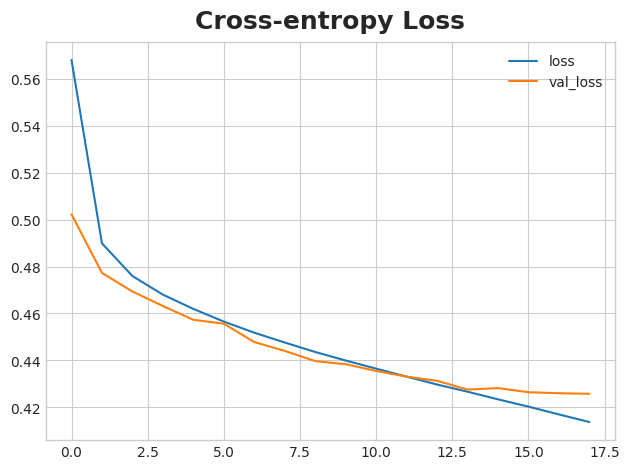

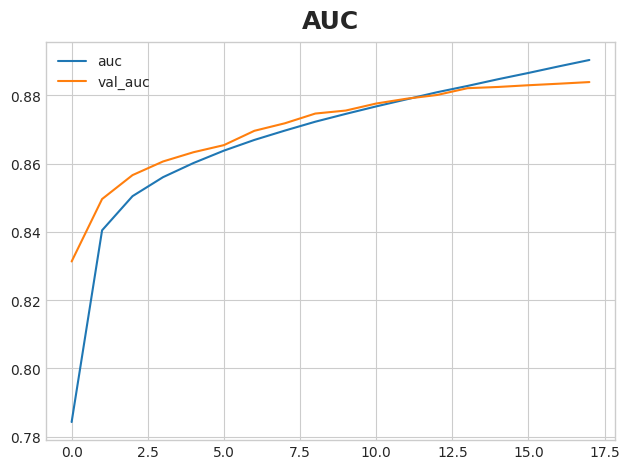

In [9]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot(title='Cross-entropy Loss')
history_frame.loc[:, ['auc', 'val_auc']].plot(title='AUC');

# References #

- Baldi, P. et al. *Searching for Exotic Particles in High-Energy Physics with Deep Learning*. (2014) ([arXiv](https://arxiv.org/abs/1402.4735))
- Cheng, H. et al. *Wide & Deep Learning for Recommender Systems*. (2016) ([arXiv](https://arxiv.org/abs/1606.07792))
- *What Exactly is the Higgs Boson?* Scientific American. (1999) [(article)](https://www.scientificamerican.com/article/what-exactly-is-the-higgs/)]

[^1]: In the original implementation, categorical features were one-hot encoded and crossed to produce the interaction features. This "wide" dataset was used with the linear component. For the deep component, the categories were encoded into a much narrower embedding layer.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/191966) to chat with other Learners.*